In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Churn prediction for game developers using Google Analytics 4 (GA4) and BigQuery ML

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/gaming_churn_prediction/churn-prediction-for-game-developers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/gaming_churn_prediction/churn-prediction-for-game-developers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/gaming_churn_prediction/churn-prediction-for-game-developers.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Table of contents

* [Overview](#section-1)
* [Objective](#section-2)
* [Dataset](#section-3)
* [Costs](#section-4)
* [Create a BigQuery dataset](#section-5)
* [Explore data](#section-6)
* [Preparing the training data](#section-7)
	* [Identifying the label for each user](#section-7-subsection-1)
    * [Extracting demographic data for each user](#section-7-subsection-2)
	* [Extracting behavioral data for each user](#section-7-subsection-3)
	* [Combining the label, demographic and behavioral data together as training data](#section-7-subsection-4)
* [Training the propensity model with BigQuery ML](#section-8)
* [Model evaluation](#section-9)
	* [Confusion matrix: predicted vs actual values](#section-9-subsection-1)
	* [ROC Curve](#section-9-subsection-2)
* [Model prediction](#section-10)  
* [Export predictions table to Cloud Storage](#section-11)
* [Clean up](#section-12)

## Overview
<a name="section-1"></a>

This tutorial shows you how to train, evaluate a propensity model in BigQuery ML to predict user retention on a mobile game, based on app measurement data from Google Analytics 4.


## Objective
<a name="section-2"></a>

In this tutorial, you learn how to train, evaluate a propensity model in BigQuery ML.

This tutorial uses the following Google Cloud ML services and resources:
* BigQuery.

The steps performed include:

* Explore an export of Google Analytics 4 data on BigQuery.
* Prepare the training data using demographic, behavioral data, and labels (churn/not-churn).
* Train an XGBoost model using BigQuery ML.
* Evaluate a model using BigQuery ML.
* Make predictions on which users will churn using BigQuery ML.

## Dataset
<a name="section-3"></a>

This notebook uses [this public BigQuery dataset](https://console.cloud.google.com/bigquery?p=firebase-public-project&d=analytics_153293282&t=events_20181003&page=table), which contains raw event data from a real mobile gaming app called Flood It! ([Android app](https://play.google.com/store/apps/details?id=com.labpixies.flood), [iOS app](https://itunes.apple.com/us/app/flood-it!/id476943146?mt=8)). The [data schema](https://support.google.com/analytics/answer/7029846) originates from Google Analytics for Firebase, but is the same schema as [Google Analytics 4](https://support.google.com/analytics/answer/9358801); the techniques in this notebook can be applied to either Google Analytics for Firebase or Google Analytics 4 data.

Google Analytics 4 (GA4) uses an [event-based](https://support.google.com/analytics/answer/9322688) measurement model. Events provide insight on what is happening in an app or on a website, such as user actions, system events, or errors. Every row in the dataset is an event, with various characteristics relevant to that event stored in a nested format within the row. While Google Analytics logs many types of events already by default, developers can also customize the types of events they also wish to log.

Note that as you cannot simply use the raw event data to train a machine learning model, this notebook shows you some important steps of how to pre-process the raw data into an appropriate format to use as training data for classification models.

## Costs
<a name="section-4"></a>

This tutorial uses the following billable components of Google Cloud:

* Vertex AI
* BigQuery
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery
pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages


In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

In [2]:
! pip3 install {USER_FLAG} --upgrade pandas-gbq 'google-cloud-bigquery[bqstorage,pandas]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.9/211.9 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 2.34.4
    Uninstalling google-cloud-bigquery-2.34.4:
      Successfully uninstalled google-cloud-bigquery-2.34.4
  Attempting uninstall: pandas-gbq
    Found existing installation: pandas-gbq 0.17.7
    Uninstalling pandas-gbq-0.17.7:
      Successfully uninstalled pandas-gbq-0.17.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.16.1 requires google-cloud-bigquery<3.0.0dev,>=1.15.0, but you have google-cloud-bigquery 3.3.1 which is incompatible.


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [3]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: vertex-ai-dev


In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. It is recommended that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [4]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [5]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.


In [6]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [7]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [8]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://vertex-ai-devaip-4z9tpjlm/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [9]:
! gsutil ls -al $BUCKET_URI

### Import libraries and define constants

In [10]:
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.bigquery import Client

#### Initialize BigQuery Client

In [11]:
client = Client(project=PROJECT_ID)

## Create a BigQuery dataset
<a name="section-5"></a>


If you are using ***Vertex AI Workbench managed notebooks instance***, every cell which starts with "#@bigquery" will be a SQL Query. If you are using Vertex AI Workbench user managed notebooks instance or Colab it will be a markdown cell.

In this notebook, you create a dataset in your project. To create it, run the following cell:

#@bigquery
-- create a dataset in BigQuery

CREATE SCHEMA bqmlga4
OPTIONS(
  location="us"
  )

(**Optional**)If you are using Vertex AI Workbench managed notebooks instance, once the results from BigQuery are displayed in the above cell, click the **Query and load as DataFrame** button and execute the generated code stub to fetch the data into the current notebook as a dataframe.

*Note: By default the data is loaded into a `df` variable, though this can be changed before executing the cell if required.*

In [12]:
dataset_id = "bqmlga4"+"_"+UUID

In [13]:
query = """
CREATE SCHEMA `{PROJECT_ID}.{dataset_id}`
OPTIONS(
  location="us"
  )
""".format(
    PROJECT_ID=PROJECT_ID, dataset_id=dataset_id
)
query_job = client.query(query)

print(query_job.result())

## Explore data
<a name="section-6"></a>


The sample dataset contains raw event data, as shown in the next cell:


In [14]:
query = """
SELECT 
    *
FROM
  `firebase-public-project.analytics_153293282.events_*`
    
LIMIT 5
"""
query_job = client.query(query)

In [15]:
query_job.to_dataframe()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20180907,1536318204637000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",<NA>,NaN,12,-1337527,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
1,20180907,1536318185637001,level_up,"[{'key': 'level_name', 'value': {'string_value...",<NA>,NaN,12,-1337527,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
2,20180907,1536318212553000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",1536318122637000,NaN,13,-1326405,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
3,20180907,1536318151553003,level_up,"[{'key': 'level_name', 'value': {'string_value...",1536318122637003,NaN,13,-1326405,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
4,20180907,1536318252285000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",1536318145553000,NaN,14,-1254437,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None


It may be helpful to take a look at the overall schema used in Google Analytics 4. As mentioned earlier, Google Analytics 4 uses an event-based measurement model and each row in this dataset is an event. [View the complete schema and details about each column](https://support.google.com/analytics/answer/7029846). As you can see above, specific columns are nested records and contain detailed information:

* `app_info`
* `device`
* `ecommerce`
* `event_params`
* `geo`
* `traffic_source`
* `user_properties`
* `items` (present by default in GA4 datasets)
* `web_info` (present by default in GA4 datasets)

The query results below show that there are 15K users and 5.7M events in this dataset:

#@bigquery
SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

In [16]:
query = """
SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`
"""
query_job = client.query(query)

In [17]:
query_job.to_dataframe()

,count_distinct_users,count_events
0,15175,5700000


## Preparing the training data
<a name="section-7"></a>


You cannot simply use raw event data to train a machine learning model as it would not be in the right shape and format to use as training data. So in this section, you learn how to pre-process the raw data into an appropriate format to use as training data for classification models.


To predict which user is going to _churn_ or _return_, the ideal training data format for classification should look like the following:  


|User ID|User demographic data|User behavioral data|Churned|
|-|-|-|-|
|User1|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1
|User2|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|0
|User3|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1


Characteristics of the training data:
- Each row is a separate unique user ID
- Feature(s) for **demographic data**
- Feature(s) for **behavioral data**
- The actual **label** that you want to train the model to predict (for example, 1 = churned, 0 = returned)

You can train a model with only demographic data or behavioral data, but having a combination of both likely help you create a more predictive model. For this reason, in this section, you learn how to pre-process the raw data to follow this training data format.

The following sections walk you through preparing the demographic data, behavioral data, and the label before joining them all together as the complete training dataset. The steps are:

1. Identify the label for each user (churned or returned)
1. Extract demographic data for each user
1. Extract behavioral data for each user
1. Combine the label, demographic data, and behavioral data together as training data

#### Step 1: Identify the label for each user
<a name="section-7-subsection-1"></a>

The raw dataset doesn't have a feature that simply identifies users as "churned" or "returned", so in this section, you need to create this label based on some of the existing columns.

There are many ways to define user churn, but for the purposes of this notebook, you predict 1-day churn as users who do not come back and use the app again after 24 hours of the user's first engagement. 

In other words, after 24 hours of a user's first engagement with the app:
- if the user _shows no event data thereafter_, the user is considered **churned**. 
- if the user _does have at least one event datapoint thereafter_, then the user is considered **returned**

You may also want to remove users who were unlikely to have ever returned anyway after spending just a few minutes with the app, which is sometimes referred to as "bouncing". For example, you may want to build the model only on users who spent at least 10 minutes with the app (users who did not bounce).

So your updated definition of a **churned user** for this notebook is:
> "any user who spent at least 10 minutes on the app, but after 24 hours from when they first engaged with the app, never used the app again"


In SQL, since the raw data contains all of the events for every user, from their first touch (app installation) to their last touch, you can use this information to create two columns: `churned` and `bounced`.


Take a look at the following SQL query and the results:

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  bqmlga4.returningusers 
LIMIT 100;

In [18]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  {dataset_id}.returningusers 
LIMIT 100;
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [19]:
query_job.to_dataframe()

,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,8FA82E7952616AA4904B29201BDC06FB,1529592738767000,1535981223479000,6,172,5,1529679138767000,0,0
1,55BFC405FFA33C0781DE73101011E45B,1528815513057008,1538505214830059,6,163,3,1528901913057008,0,0
2,FD73CD8F923981553C861D7ACCE76D27,1534191152076007,1534727882268008,8,225,2,1534277552076007,0,0
3,E4C6FF8288DD4BFCDE93E2218E20643B,1529483570594009,1538522310024003,6,171,4,1529569970594009,0,0
4,A7AAA5EF977926DBCF801D15F83EE4A5,1529343025472000,1538403816508017,6,169,2,1529429425472000,0,0
...,...,...,...,...,...,...,...,...,...
95,74456352647C13028F89D1EEFFB905F4,1529090479571009,1538614064123010,6,166,6,1529176879571009,0,0
96,934A101CA7B97944D05E0FC2ED3E203D,1529967513268011,1535940065562229,6,176,2,1530053913268011,0,0
97,28628F10D43B6D507B38A10B4366EAD9,1530269710246010,1538122274159036,6,180,6,1530356110246010,0,0
98,B6DC9436388A5BA0ABF0DA25C28A1AD9,1530315314659000,1534493306688051,6,180,6,1530401714659000,0,0


#@bigquery
SELECT 
  * 
FROM 
  bqmlga4.returningusers 

In [20]:
query = """
SELECT 
  * 
FROM 
  {dataset_id}.returningusers 
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [21]:
query_job.to_dataframe()

,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,50DF4D37167497C4DD0F00E2CCAE39C0,1535366692786010,1538420148113003,8,239,2,1535453092786010,0,0
1,B6E6FA98F04FE22CC272DB5183B48763,1533865615944006,1534299919942001,8,222,6,1533952015944006,0,0
2,F3CA6D208932C0BD365FE0D589038E1C,1532027936927003,1538520676671175,7,200,5,1532114336927003,0,0
3,1C93EDC08BD29847559EC3853A9D5C80,1534432196161002,1534740209730000,8,228,5,1534518596161002,0,0
4,45DF5BA054826C546308F865405709B3,1534303646253004,1534403519909014,8,227,4,1534390046253004,0,0
...,...,...,...,...,...,...,...,...,...
13583,A89BC996120727ACE4C955CA37F0E042,1536736108951003,1536736337206013,9,255,4,1536822508951003,1,1
13584,86FD44981AC5E1E744A44F2D34ABAC45,1536780494014005,1536780568416012,9,255,4,1536866894014005,1,1
13585,D06BDD028F9A83D653B3CD89F8506395,1536719476308007,1536719653279010,9,255,4,1536805876308007,1,1
13586,7828669F8CF78F49123282361488CF7C,1536734054985005,1536734215580005,9,255,4,1536820454985005,1,1


For the `churned` column, `churned = 0` if the user performs an action after 24 hours since their first touch, otherwise if their last action was only within the first 24 hours, then `churned = 1`.


For the `bounced` column, `bounced = 1` if the user's last action was within the first ten minutes since their first touch with the app, otherwise `bounced = 0`. You can use this column to filter the training data later on by conditionally querying for users where `bounced = 0`.

You might wonder how many of these 15k users bounced and returned? You can run the following query to check:

#@bigquery
SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.returningusers
GROUP BY 1,2
ORDER BY bounced

In [22]:
query = """
SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    {dataset_id}.returningusers
GROUP BY 1,2
ORDER BY bounced
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [23]:
query_job.to_dataframe()

,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


For the training data, you only end up using data where `bounced = 0`. Based on the 15k users, you can see that 5,557 (\~41%) users bounced within the first ten minutes of their first engagement with the app, but of the remaining 8,031 users, 1,883 users (\~23%) churned after 24 hours.

#@bigquery
SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.returningusers
WHERE bounced = 0

In [24]:
query = """
SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    {dataset_id}.returningusers
WHERE bounced = 0
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [25]:
query_job.to_dataframe()

,churn_rate
0,0.234466


There are 23% churners in the data which is not bad for training a churn prediction model. If the class imbalance seems to be high, oversampling or undersampling techniques can be considered to balance the class distribution.

#### Step 2: Extract demographic data for each user
<a name="section-7-subsection-2"></a>


This section is focused on extracting the demographic information for each user. Different demographic information about the user is available in the dataset already, including `app_info`, `device`, `ecommerce`, `event_params`, and `geo`. Demographic features can help the model predict whether users on certain devices or countries are more likely to churn.

For this notebook, you can start just with `geo.country`, `device.operating_system`, and `device.language`. If you are using your own dataset and have joinable first-party data, this section is a good opportunity to add any additional attributes for each user that may not be readily available in Google Analytics 4.

Note that a user's demographics may occasionally change (e.g. moving from one country to another). For simplicity, you just use the demographic information that Google Analytics 4 provides when the user LAST engaged with the app as indicated by `MAX(event_timestamp)`. This enables every unique user to be represented by a single row.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

In [26]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  {dataset_id}.user_demographics
LIMIT 10
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [27]:
query_job.to_dataframe()

,user_pseudo_id,country,operating_system,language
0,0046A2D1B1135C0AB4462B8FF036739E,Canada,ANDROID,en-ca
1,004D2DFEB866BFB00427DB2F530C1F3D,United States,ANDROID,en-us
2,022DBC0027417922D926ECA6B96E53D6,United States,ANDROID,en-us
3,03896D205DD7A729C6D1269749A0267A,India,None,en-in
4,04D1448BED7366A1CACEDA442F7A18D8,Canada,IOS,en-ca
5,062964F7169622E4AEC91756FFB8261B,Brazil,IOS,pt-br
6,094F4CF1AA8C39F4379CC791CC65DBD7,United States,IOS,en-us
7,0969A1FA5300A40F4CFA6AE5BD539DE4,India,ANDROID,en-in
8,0A4392C9AF54229E5C3348DF9370AF00,United States,None,en-us
9,0B986C511C4A24115798B4749E27F775,United Kingdom,IOS,en-gb


#@bigquery
SELECT
  *
FROM
  bqmlga4.user_demographics


In [28]:
query = """
SELECT
  *
FROM
  {dataset_id}.user_demographics
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [29]:
query_job.to_dataframe()

,user_pseudo_id,country,operating_system,language
0,1A3C9B890548F1BCE865FC5422E08672,Ecuador,ANDROID,es-us
1,47A3ACCCFB629C52C44277177265496C,Hong Kong,ANDROID,en-us
2,587B7361E91394D3BB6B8214672C4B91,Hungary,ANDROID,hu-hu
3,58A8D09A7936F0D53FBD1E478BF23320,Namibia,ANDROID,en-na
4,6A5E7CE6B78C0E8559C23E1E45411CCC,Austria,IOS,de-at
...,...,...,...,...
13583,664FEC313A016F2E48DCD1FAE7A28B85,United Kingdom,IOS,en-gb
13584,8558D5249FC196564CFD6ACD4FFA7F0A,United Kingdom,IOS,en-gb
13585,899025E230D60C049CE84BE950238FC6,United Kingdom,IOS,en-gb
13586,BF117A1E25AC14A1F1F68D104AFEB18D,United Kingdom,ANDROID,en-gb


#### Step 3: Extract behavioral data for each user
<a name="section-7-subsection-3"></a>

Behavioral data in the raw event data spans across multiple events -- and thus rows -- per user. The goal of this section is to aggregate and extract behavioral data for each user, resulting in one row of behavioral data per unique user.

But what kind of behavioral data you need to prepare? Since the end goal of this notebook is to predict, based on a user's activity within the first 24 hours since app installation, whether that user will churn or return thereafter, then you want to use behavioral data from the first 24 hours in your training data. Later on, you can also extract some extra time-related features from `user_first_engagement`, such as the month or day of the first engagement.

Google Analytics automatically collects [specific events](https://support.google.com/analytics/answer/6317485) that you can use to analyze behavior. In addition, there are recommended [events for games](https://support.google.com/analytics/answer/6317494). 


As a first step, you can explore all the unique events that exist in this dataset, based on `event_name`:

#@bigquery
SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC

In [30]:
query = """
SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC
"""
query_job = client.query(query)

In [31]:
query_job.to_dataframe()

,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


For this tutorial, to predict whether a user will churn or return, you can start by counting the number of times a user engages in the following event types:

* `user_engagement`
* `level_start_quickplay`
* `level_end_quickplay`
* `level_complete_quickplay`
* `level_reset_quickplay`
* `post_score`
* `spend_virtual_currency`
* `ad_reward`
* `challenge_a_friend`
* `completed_5_levels`
* `use_extra_steps`

In SQL, you can aggregate the behavioral data by calculating the total number of times when each of the above `event_names` occurred in the dataset per user.

If you are using your own dataset, you may have different event types that you can aggregate and extract. Your app may be sending very different `event_names` to Google Analytics so be sure to use events suitable to your scenario.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior
LIMIT 10


In [32]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      {dataset_id}.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  {dataset_id}.user_aggregate_behavior
LIMIT 10

""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [33]:
query_job.to_dataframe()

,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,F0D69C1A2EDD21068162B3E18D07A030,7,2,1,0,0,0,0,0,0,0,0
1,E72E512B6F4FD9E672F5E50F3C8FF0DC,2,0,0,0,0,0,0,0,0,0,0
2,B15282DB02B212BED10AEA25F793A127,7,2,2,2,0,2,0,0,0,0,0
3,5E694DE02688C2FDDEA38A6946A4CC3F,6,3,2,1,0,1,0,0,0,0,0
4,84D135997D8A4D9CB35D4ECA46EF6861,20,4,3,3,0,3,3,0,0,0,3
5,575184A9EBACE52D2CEEEC60621F934B,12,5,4,2,0,2,0,0,0,0,0
6,6CB48CA793FC0BCDD963C1488371447F,33,12,5,4,4,4,0,0,0,0,0
7,3A775A1384079D73CA3DDBB985CC6250,7,2,2,1,0,1,0,0,0,0,0
8,377303AA2F5C5C80E5AAAD26C029BD5A,55,21,19,19,0,19,0,0,0,0,0
9,31DF612CC7704C453889C7836C5F1A63,269,3,2,0,0,28,0,0,0,0,0


#### Step 4: Combine the label, demographic data, and behavioral data together as training data
<a name="section-7-subsection-4"></a>

In this section, you can now combine these three intermediary views (label, demographic data, and behavioral data) into the final training dataset. Here you can also specify `bounced = 0`, in order to limit the training data only to users who did not "bounce" within the first 10 minutes of using the app.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.train AS (
    
  SELECT
    dem.*,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.month,
    ret.julianday,
    ret.dayofweek,
    ret.churned
  FROM
    bqmlga4.returningusers ret
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.train
LIMIT 10

In [34]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.train AS (
    
  SELECT
    dem.*,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.month,
    ret.julianday,
    ret.dayofweek,
    ret.churned
  FROM
    {dataset_id}.returningusers ret
  LEFT OUTER JOIN
    {dataset_id}.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    {dataset_id}.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  {dataset_id}.train
LIMIT 10
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [35]:
query_job.to_dataframe()

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
0,69541D4D4F182FBB46C3225DA0077DDD,United States,ANDROID,en-us,14,1,0,0,0,3,0,0,0,0,0,1536993733717001,9,258,7,0
1,4AEEE533D8FAED4AD0A9227618CD296B,Japan,ANDROID,ja-jp,294,111,88,39,20,39,0,0,0,0,0,1536881216846000,9,256,5,0
2,CCC7BB053BBC6824C53FAA4A8C63E3FE,Nigeria,ANDROID,en-us,36,1,0,0,0,7,2,0,0,1,2,1536074181682003,9,247,3,0
3,BEC04B2A3A5CC892BE0907C44F5F921F,United States,ANDROID,en-us,4,2,1,0,0,1,0,0,0,0,0,1529305708372004,6,169,2,0
4,24D41A78A6BB1244608DB32351B0658B,United States,IOS,en-us,9,4,2,1,0,1,0,0,0,0,0,1528850519589009,6,164,4,0
5,03E05B9F728257B2F739CF0BB4497166,Mexico,IOS,es-mx,22,5,5,2,0,2,0,0,0,0,0,1536816874999009,9,256,5,0
6,B4B344058D0734922CF28259E53FECDF,Denmark,IOS,da-dk,4,1,1,0,0,0,0,0,0,0,0,1537160908478003,9,260,2,0
7,0808B3380E616BDF15E6F2FBAF38147F,United States,IOS,en,20,7,6,2,0,2,0,0,0,0,0,1535940200667000,9,246,2,0
8,86942BEBB6333C69BD5EADC72AC04A3E,United States,IOS,en-us,45,14,13,4,0,4,0,0,0,0,0,1531370439928003,7,193,5,0
9,DAD2E26F6C0E4C6631490AC31BF2DBC8,Malaysia,ANDROID,en-us,26,0,0,0,0,4,0,0,0,0,0,1535731808478001,8,243,6,0


#@bigquery
SELECT
  *
FROM
  bqmlga4.train

In [36]:
query = """
SELECT
  *
FROM
  {dataset_id}.train
""".format(dataset_id=dataset_id)
query_job = client.query(query)
df = query_job.to_dataframe()

In [37]:
df

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
0,FA30269453141794E79B8F15EE0BA5B9,Japan,ANDROID,ja-jp,32,15,13,0,0,13,0,0,0,0,0,1529318897792006,6,169,2,0
1,F266753CA2B28C65DE2762CEE177AA78,United States,ANDROID,en-us,4,2,2,0,0,4,0,0,0,0,0,1529386082277004,6,170,3,0
2,59BE43F3FE7AB3F91B016B56508D4C46,United States,ANDROID,en-us,10,4,2,2,0,2,0,0,0,0,0,1529072042300009,6,166,6,0
3,39AE34F91B29542A8F0488F5B787B70F,Australia,ANDROID,en-au,5,2,1,0,0,1,0,0,0,0,0,1529980640090004,6,177,3,0
4,184FAE1A4D9A74D077E3D2DDD433C1C9,United States,IOS,en-us,27,9,8,2,0,2,0,0,0,0,0,1528863621024012,6,164,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8026,461ED15685A45FB403394E9A91F729A6,United States,ANDROID,en-us,12,1,0,0,0,1,0,0,0,0,0,1533803730691005,8,221,5,1
8027,66163D6663552C5C43D3DB1D98FCA9DA,United States,ANDROID,en-us,156,0,0,0,0,26,2,0,0,1,2,1533870785581005,8,222,6,1
8028,40A81A69B84A84C1E7577605FA47594C,Canada,IOS,en-ca,12,4,3,2,0,2,0,0,0,0,0,1535313783316001,8,238,1,1
8029,3F4C49B7D999DB0D286AA09BED5C04A9,United Kingdom,ANDROID,en-gb,12,5,2,1,1,1,0,0,0,0,0,1535822855359011,9,244,7,1


Check the percentage of null values.

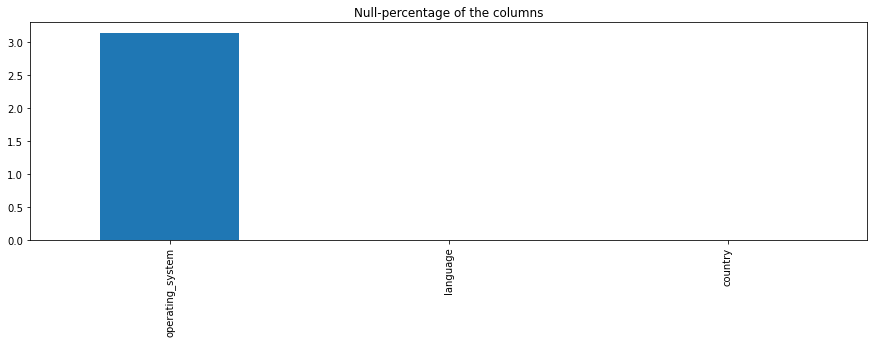

In [38]:
(
    100 * df[["operating_system", "language", "country"]].isna().sum() / df.shape[0]
).plot.bar(figsize=(15, 4))
plt.title("Null-percentage of the columns")
plt.show()

## Training the propensity model with BigQuery ML
<a name="section-8"></a>


In this section, using the training data you prepared, you now train machine learning models in SQL using BigQuery ML.

You use an [XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) model here. In this notebook, the model predicts whether the user will churn (1) or return (0) after 24 hours of the user's first engagement with the app.


#### Train an XGBoost model

The following code trains an XGBoost model. This may take several minutes.

For more information on the default hyperparameters used, see [The CREATE MODEL statement for boosted tree models using XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree).

#@bigquery
CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  DATA_SPLIT_METHOD='RANDOM',
  DATA_SPLIT_EVAL_FRACTION=0.2,
    
  INPUT_LABEL_COLS=["churned"]
) AS

SELECT
  *
FROM
  bqmlga4.train

In [43]:
query = """
CREATE OR REPLACE MODEL {dataset_id}.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  DATA_SPLIT_METHOD='RANDOM',
  DATA_SPLIT_EVAL_FRACTION=0.2,
    
  INPUT_LABEL_COLS=["churned"]
) AS

SELECT
  *
FROM
  {dataset_id}.train
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [44]:
query_job.result()

## Model evaluation
<a name="section-9"></a>


To evaluate the model, you can run [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) on a model that has finished training to inspect some of the metrics.

The metrics are based on the test sample data that was automatically split during model creation ([see the CREATE MODEL documentation for more information](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method)).

#@bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb)


In [45]:
query = """
SELECT
  *
FROM
  ML.EVALUATE(MODEL {dataset_id}.churn_xgb)
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [46]:
query_job.to_dataframe()

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.544218,0.223464,0.779271,0.316832,0.447193,0.777318


`ML.EVALUATE` generates the `precision`, `recall`, `accuracy`, and `f1_score` using the default classification threshold of 0.5, which can be modified by using the optional [`THRESHOLD`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#eval_threshold) parameter.

Generally speaking, you can use the `log_loss` and `roc_auc` metrics to compare  model performance.

The `log_loss` ranges between 0 and 1.0, and the closer the `log_loss` is to zero, the closer the predicted labels were to the actual labels.

The `roc_auc` ranges between 0 and 1.0, and the closer the `roc_auc` is to 1.0, the better the model is at distinguishing between the classes.

For more information on these metrics, you can read through the definitions on [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [f1-score](https://en.wikipedia.org/wiki/F-score), [log_loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss) and [roc_auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

#### Confusion matrix: predicted vs actual values
<a name="section-9-subsection-1"></a>


In addition to model evaluation metrics, you may also want to use a confusion matrix to inspect how well the model predicted the labels, compared to the actual labels.

With the rows indicating the actual labels, and the columns as the predicted labels, the resulting format for ML.CONFUSION_MATRIX for binary classification looks like:

| | Predicted_0 | Predicted_1|
|-|-|-|
|Actual_0| True Negatives | False Positives|
|Actual_1| False Negatives | True Positives|

For more information on confusion matrices, see [Classification: True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

#@bigquery
SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)

In [47]:
query = """
SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL {dataset_id}.churn_xgb)
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [48]:
query_job.to_dataframe()

,expected_label,predicted_0,predicted_1
0,0,1138,67
1,1,278,80


#### ROC Curve
<a name="section-9-subsection-2"></a>


#@bigquery
SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

In [49]:
query = """
SELECT * FROM ML.ROC_CURVE(MODEL {dataset_id}.churn_xgb)
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [50]:
query_job.to_dataframe()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.953608,0.002793,0.000000,1,0,1205,357
1,0.806140,0.036313,0.002490,13,3,1202,345
2,0.716526,0.064246,0.007469,23,9,1196,335
3,0.647602,0.089385,0.012448,32,15,1190,326
4,0.589544,0.111732,0.019087,40,23,1182,318
...,...,...,...,...,...,...,...
91,0.034754,1.000000,0.912863,358,1100,105,0
92,0.033828,1.000000,0.926141,358,1116,89,0
93,0.033014,1.000000,0.946058,358,1140,65,0
94,0.032932,1.000000,0.950207,358,1145,60,0


## Model prediction
<a name="section-10"></a>


You can run [`ML.PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) to make predictions on the propensity to churn. The following code returns all of the information from `ML.PREDICT`.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.prediction_data AS(
(SELECT * FROM bqmlga4.train where churned=1 limit 10)
union all
(SELECT * FROM bqmlga4.train where churned=0 limit 20))

In [51]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.prediction_data AS(
(SELECT * FROM {dataset_id}.train where churned=1 limit 10)
union all
(SELECT * FROM {dataset_id}.train where churned=0 limit 20))
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [52]:
query_job.result()

#@bigquery
SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.prediction_data)
            ) 

In [53]:
query = """
SELECT
  *
FROM
  ML.PREDICT(MODEL {dataset_id}.churn_xgb,
  (SELECT * FROM {dataset_id}.prediction_data)
            ) 
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [54]:
query_job.to_dataframe()

,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,...,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
0,0,"[{'label': 1, 'prob': 0.09550435096025467}, {'...",E6850F5E0DAB3E339C6A36BDEECCA26F,United States,ANDROID,en-us,98,36,33,17,...,0,0,0,0,0,1529703038951003,6,173,6,0
1,0,"[{'label': 1, 'prob': 0.17157793045043945}, {'...",0A32F2B531D2B15D8D8360E7F079E0E4,Taiwan,ANDROID,zh-tw,10,1,0,0,...,0,0,0,0,0,1529981014123022,6,177,3,0
2,0,"[{'label': 1, 'prob': 0.16646809875965118}, {'...",967F40F4C525E024B52809F7115718C0,Canada,ANDROID,en-ca,8,14,1,0,...,0,0,0,0,0,1529512982457027,6,171,4,0
3,0,"[{'label': 1, 'prob': 0.18851225078105927}, {'...",98A5DBAFFB2FB2E7C47D7CE87A25A10D,United States,ANDROID,en-us,7,2,1,0,...,0,0,0,0,0,1530241822766001,6,180,6,0
4,0,"[{'label': 1, 'prob': 0.07661151885986328}, {'...",05407E04B9FA64CB63D8FA1D966AD6A2,Canada,ANDROID,en-ca,14,5,4,0,...,0,0,0,0,0,1529357952362000,6,169,2,0
5,0,"[{'label': 1, 'prob': 0.046552252024412155}, {...",4D084D38156128AAA060303AA91E689D,Brazil,ANDROID,pt-br,3,1,1,1,...,0,0,0,0,0,1529605105519003,6,172,5,0
6,0,"[{'label': 1, 'prob': 0.03199450299143791}, {'...",4A47422A455E62E3529DE4F9F3BFAF66,Australia,ANDROID,en-au,21,1,1,0,...,0,0,0,0,0,1528883888753006,6,164,4,0
7,0,"[{'label': 1, 'prob': 0.08301331102848053}, {'...",51B215871E81C64077434452838DE86A,Greece,ANDROID,en-gb,3,1,0,0,...,0,0,0,0,0,1530250686086004,6,180,6,0
8,0,"[{'label': 1, 'prob': 0.035370588302612305}, {...",CE3E59F2C2C3BD7F1C8FB80D53CF0F3B,United States,ANDROID,en-us,1,0,0,0,...,0,0,0,0,0,1529961268174003,6,176,2,0
9,0,"[{'label': 1, 'prob': 0.40181204676628113}, {'...",64BA3BB3BD757CE7000D38CB7125E6DA,Mexico,ANDROID,en-us,19,8,3,0,...,0,0,0,0,0,1530236655133001,6,180,6,0


For propensity modeling, the most important output is the probability of a behavior occuring. The following query returns the probability that the user will return after 24 hours. The higher the probability and closer it is to 1, the more likely the user is predicted to churn, and the closer it is to 0, the more likely the user is predicted to return.

#@bigquery
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.train))

In [55]:
query = """
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL {dataset_id}.churn_xgb,
  (SELECT * FROM {dataset_id}.train))
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [56]:
query_job.to_dataframe()

,user_pseudo_id,churned,predicted_churned,probability_churned
0,B86E09CD1E5DA0373D508647973EA921,1,0,0.315722
1,B1CF7C5402E96CC7C7573A11FCBFF213,0,0,0.038282
2,13F95513D979142F2AECF50C8D14383E,0,0,0.311880
3,3827BA312204EA6F6847DFA4222C90CC,0,0,0.362814
4,093642BD46204EB5F950303CE696BC18,0,0,0.332512
...,...,...,...,...
8026,2E90EC26A8024356FD9CDA9654D7E3D9,1,0,0.383013
8027,E86172232E47B44315B97460C0F407C8,1,1,0.695704
8028,C08E0DCBBC8F969D51C14B0E479EA9FA,1,1,0.557076
8029,0FB030B897D1A6360CCD8CCBF9031755,1,0,0.373928


## Export the predictions table to Cloud Storage
<a name="section-11"></a>

There are several ways to export the predictions table to Cloud Storage, so that you can use the information in a separate service. Perhaps the easiest way is to export directly to Cloud Storage using SQL. [Learn more about the EXPORT DATA statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/other-statements#export_data_statement).

In [57]:
query = """
CREATE OR REPLACE TABLE {dataset_id}.prediction_data_table AS (
SELECT 
  * 
FROM 
  {dataset_id}.prediction_data
)
""".format(dataset_id=dataset_id)
query_job = client.query(query)

In [58]:
query_job.result()

In [59]:
FILE_PATH = BUCKET_URI + "/" + "*.csv"

In [62]:
query = """
EXPORT DATA OPTIONS (
uri= @FILE_PATH, 
  format=CSV,
  header=True, 
  overwrite=True 
    
) AS 
SELECT
  * from {dataset_id}.prediction_data_table
""".format(dataset_id=dataset_id)

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("FILE_PATH", "STRING", FILE_PATH),
    ]
)
query_job = client.query(query, job_config=job_config)  # Make an API request.

In [63]:
query_job.result()

## Clean up
<a name="section-12"></a>

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial. The following code deletes the entire dataset.

In [64]:
# Set dataset variable to the ID of the BigQuery dataset to fetch.
dataset = f"{PROJECT_ID}.{dataset_id}"

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))

delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

Deleted dataset 'bqmlga4_4z9tpjlm'.
Removing gs://vertex-ai-devaip-4z9tpjlm/000000000000.csv#1660224757208166...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              
Removing gs://vertex-ai-devaip-4z9tpjlm/...
